# Function Approximation

Now let's try fitting some simple functions. For this problem, we will not use eager execution.

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

precision = tf.float32

print('Loaded TensorFlow version ' + tf.__version__)

Loaded TensorFlow version 1.13.1


Make some training and testing data

our training data and a piecewise linear interpolation of the data


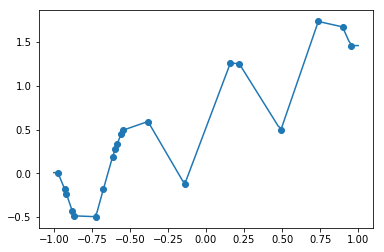

our testing data


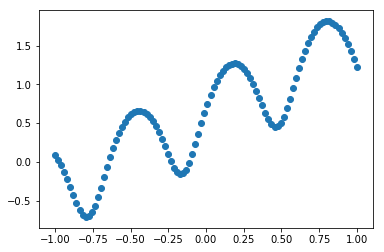

In [13]:
# number of examples for training and testing
num_train_pts = 20
num_test_pts = 100

# generate some linearly spaced points
x_test = np.linspace(-1.0, 1.0, num = num_test_pts)

# generate some uniform random samples
x_train = np.random.uniform(-1.0,1.0,num_train_pts)

# let's try to approximate y = log(sin(10x)+2) + sin(x)
y_train = np.log(np.sin(10*x_train) + 2) + np.sin(x_train)
y_test = np.log(np.sin(10*x_test) + 2) + np.sin(x_test)

print('our training data and a piecewise linear interpolation of the data')
plt.scatter(x_train,y_train)
x_train_sorted = np.sort(x_train)

indices = np.argsort(x_train)

y_train_sorted = y_train[indices[::1]]

y_interp = np.interp(x_test, x_train_sorted, y_train_sorted)
plt.plot(x_test,y_interp)
plt.show()

print('our testing data')
plt.scatter(x_test,y_test)

### Building the graph

Now let's build the computational graph

In [74]:
hidden_dim = 100
depth = 5
input_dim = 1
output_dim = 1
sigma = 0.1
epochs = 100

tf.reset_default_graph()

with tf.variable_scope('Graph') as scope:

    x = tf.placeholder(precision, shape = [1, None], name = 'input')
    y_true = tf.convert_to_tensor(y_train.reshape(1,num_train_pts), dtype = tf.float32)
    
    with tf.variable_scope('FunctionApproximator'):

        # input layer description
        in_W = tf.get_variable(name = 'in_W', shape = [hidden_dim, input_dim],
                initializer = tf.random_normal_initializer(stddev = sigma, dtype = precision),
                dtype = precision)

        in_b = tf.get_variable(name = 'in_b', shape = [hidden_dim, 1],
                initializer = tf.random_normal_initializer(stddev = sigma, dtype = precision), 
                dtype = precision)
        
        z = tf.nn.relu(tf.matmul(in_W, x) + in_b)
        
        for layer in range(depth):
            
            W = tf.get_variable(name = 'l' + str(layer) + '_W', shape = [hidden_dim, hidden_dim],
                                initializer = tf.random_normal_initializer(stddev = sigma, dtype = precision),
                                dtype = precision)

            # biases for current layer
            b = tf.get_variable(name = 'l' + str(layer) + '_b', shape = [hidden_dim, 1],
                                initializer = tf.random_normal_initializer(stddev = sigma, dtype = precision),
                                dtype = precision)
            
            z = tf.nn.relu(tf.matmul(W, z) + b)
            
        out_v = tf.get_variable(name = 'out_v', shape = [output_dim, hidden_dim],
                 initializer = tf.random_normal_initializer(stddev = sigma, dtype = precision), dtype = precision)
        y = tf.matmul(out_v, z, name = 'output')
    
    # loss function
    with tf.variable_scope('Loss'):
        # Mean squared error function
        loss = tf.losses.mean_squared_error(y, y_true)
    
    init_rate = 1e-3
    lrn_rate = init_rate
    #update_freq = 100
    #base = np.exp(update_freq/args.nb_epochs*(np.log(error_tol)-np.log(init_rate)))
    opt = tf.train.AdamOptimizer(learning_rate = lrn_rate)
    train_op = opt.minimize(loss)

Let's make a method which will split our data into batches

In [51]:
def get_batch(X_in, Y_in, batch_size):
    X_cols = X_in.shape[0]
    Y_cols = Y_in.shape[0]

    for i in range(X_in.shape[1]//batch_size):
        idx = i*batch_size + np.random.randint(0,10,(1))[0]

        yield X_in.take(range(idx,idx+batch_size), axis = 1, mode = 'wrap').reshape(X_cols,batch_size), \
              Y_in.take(range(idx,idx+batch_size), axis = 1, mode = 'wrap').reshape(Y_cols,batch_size)

Now that we have our model, let's start a session

In [75]:
#lrn_rate = init_rate*(base)**(i/update_freq)

with tf.Session() as sess:
    # init variables
    sess.run(tf.global_variables_initializer())
    
    for i in range(epochs):
        
        sess.run([loss, train_op], feed_dict = {x: x_train.reshape(1,num_train_pts)})
#        for x_in_train_batch, y_true_train_batch in get_batch(x_train, y_train, 10):
#            current_loss, _ = sess.run([loss, train_op],
#                                     feed_dict = {x: x_in_train_batch, \
#                                                  y_true: y_true_train_batch})

    y_res = sess.run([y], feed_dict = {x: x_test.reshape(1,num_test_pts)})

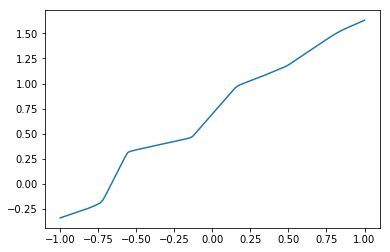

In [76]:
y_NN = y_res[0]

plt.plot(x_test,y_NN.reshape(100,1))